# Importing all the data and storing it locally

In [19]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

# Function that will read all the data from .csv files and store it in a Dataframe

In [20]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Using the load function to store data in a dataframe and display the first entries
## This is mostly to check that the data has loaded correctly

In [21]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Visualizing the data

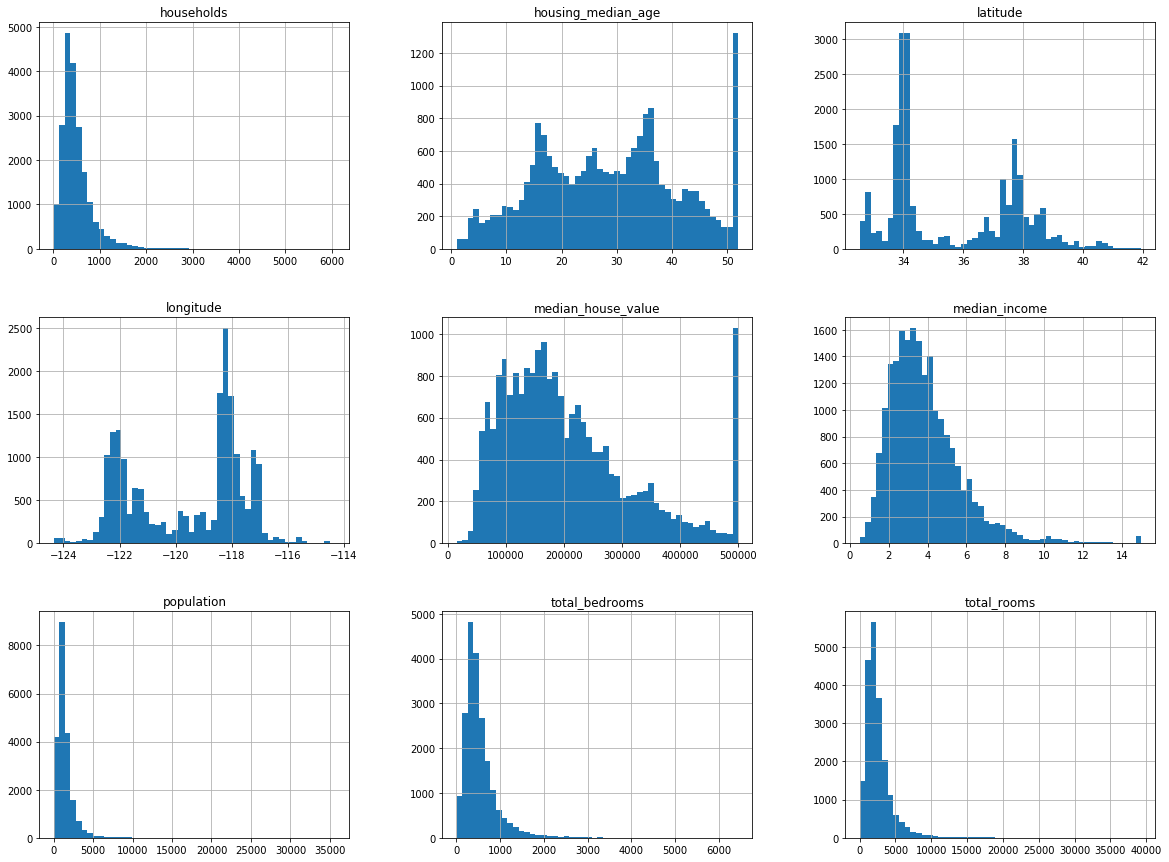

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# We now create a test set and a train set

To do this we first look at median income, as this is very important to housing prices.
Instead of simply picking random data for the test set, we will use stratified sampling to get a test set that is accuratly represented regarding meadian income.
Most meadian income values are clustered around 2-5(tens of thousand dollars).

We will divide all median incomes into 5 categories that will be used for stratified sampling.


In [24]:
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

We now have what we need to do stratified sampling on the set

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

In [27]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

We remove the **income_cat** attribute to get our original dataset back

In [28]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# Visualizing the data

We create a copy of the training dataset that we can play around with

In [30]:
housing = strat_train_set.copy()

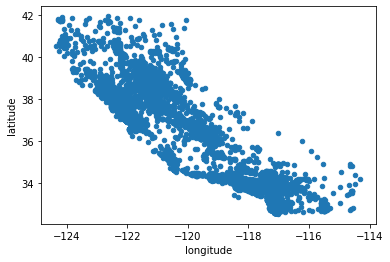

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude")

We adjust the alpha to make it easier to see where there is a high density of data points

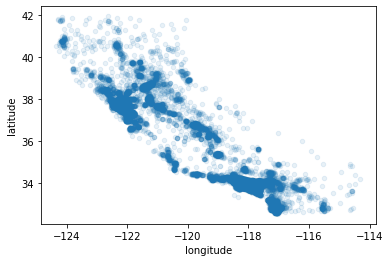

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now we take a look at the housing prices in the different areas

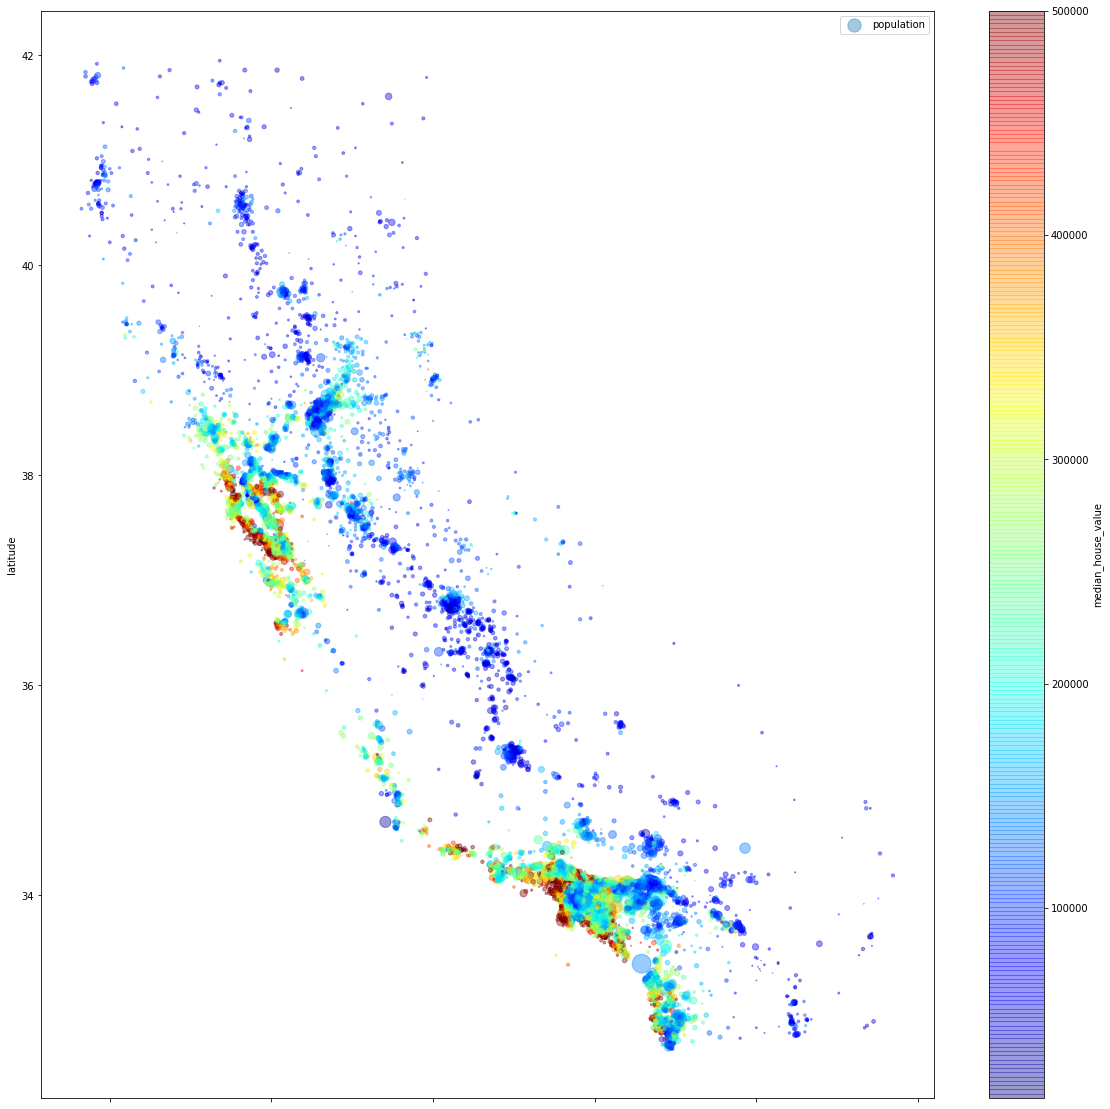

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
         s=housing["population"]/100, label="population",
         c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(20,20)
     )
plt.legend()

# Looking for correlations
We compute the standard correlation efficient between every pair of attributes.

In [38]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [39]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

We can also look for correlations using Pandas' ```scatter_matrix``` function

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc61a419650>,
      dtype=object)

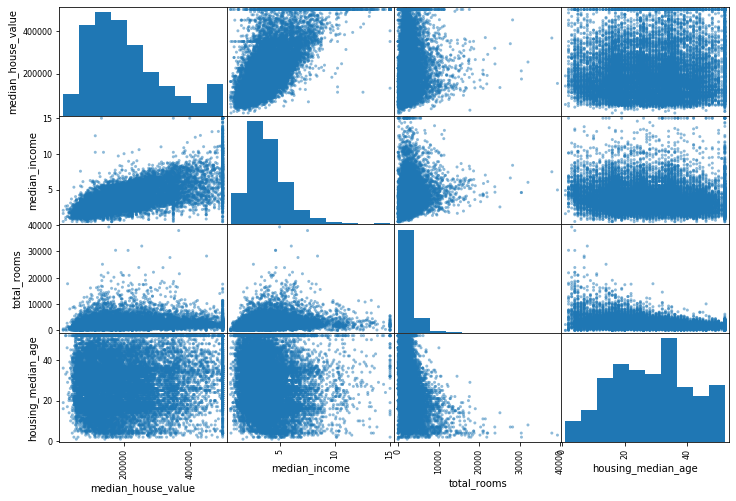

In [43]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
    "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

We zoom in on median income as this is the most promising feature

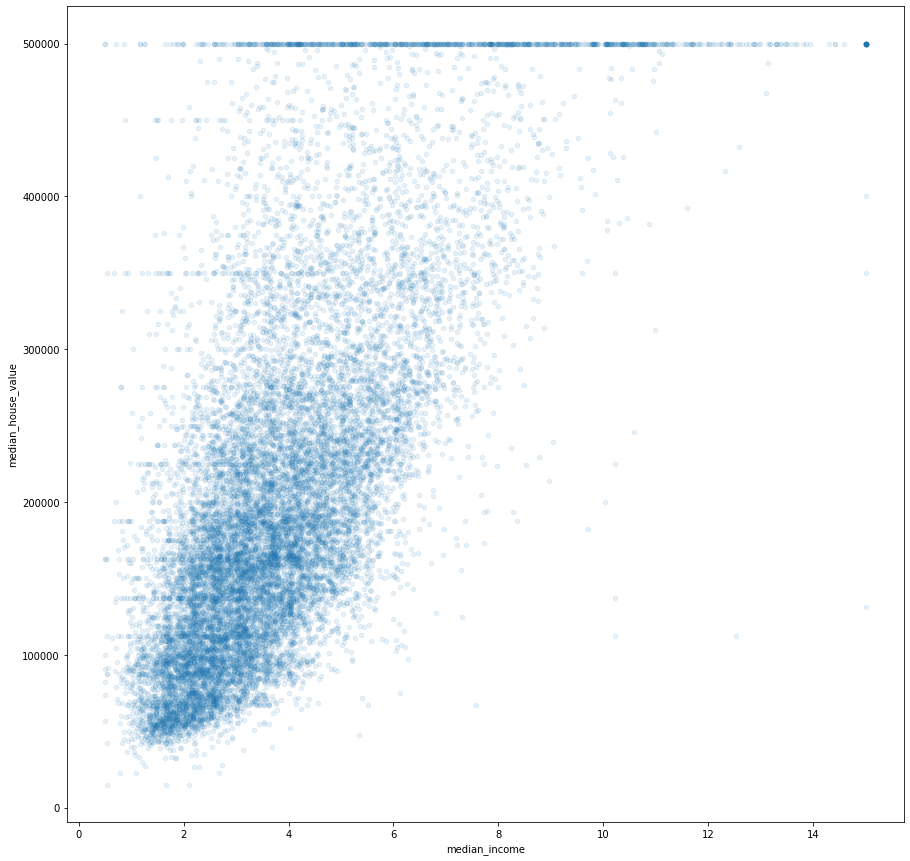

In [45]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
    alpha=0.1, figsize=(15,15))

We can clearly see the cap at 500 000$, but we also see some other horizontal lines, these might be useful to remove to avoid confusing the algorithm with these data quirks.

We create some new attributes that might prove useful to us

In [46]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [47]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

We go back to a clean dataset, and take out median house value.

In [48]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [49]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


## Data cleaning

We need to take care of missing values in the dataset.
In this case, we will calculate the median amount of bedrooms, and use this value to fill in the cells that lack any values

In [51]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
          ...  
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Length: 16512, dtype: float64

## Handling Text and Categorical Attributes
Earlier we left out the attribute ```ocean_proximity``` because it is a text attribute. We will now convert it into a numerical attrubute, so that it can be utilized.

In [53]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

These are the classes we just encode

In [54]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
